In [2]:
import torch
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.transforms as T

from collections import Counter
from pygod.metric import eval_roc_auc
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid, GitHub
from pygod.generator import gen_contextual_outlier, gen_structural_outlier
from sklearn.metrics import precision_recall_curve, average_precision_score

In [8]:
data = Planetoid('./data/Cora', 'Cora', transform=T.NormalizeFeatures())[0]

grafo = nx.Graph()

# Agregar nodos al grafo
for i in range(data.num_nodes):
    grafo.add_node(i)

# Agregar aristas al grafo
edge_index = data.edge_index.t().tolist()
grafo.add_edges_from(edge_index)


n_nodos = grafo.number_of_nodes()
n_aristas = grafo.number_of_edges()
clases = np.unique(grafo)

print(f"Número de nodos: {n_nodos}")
print(f"Número de aristas: {n_aristas}")


Número de nodos: 2708
Número de aristas: 5278


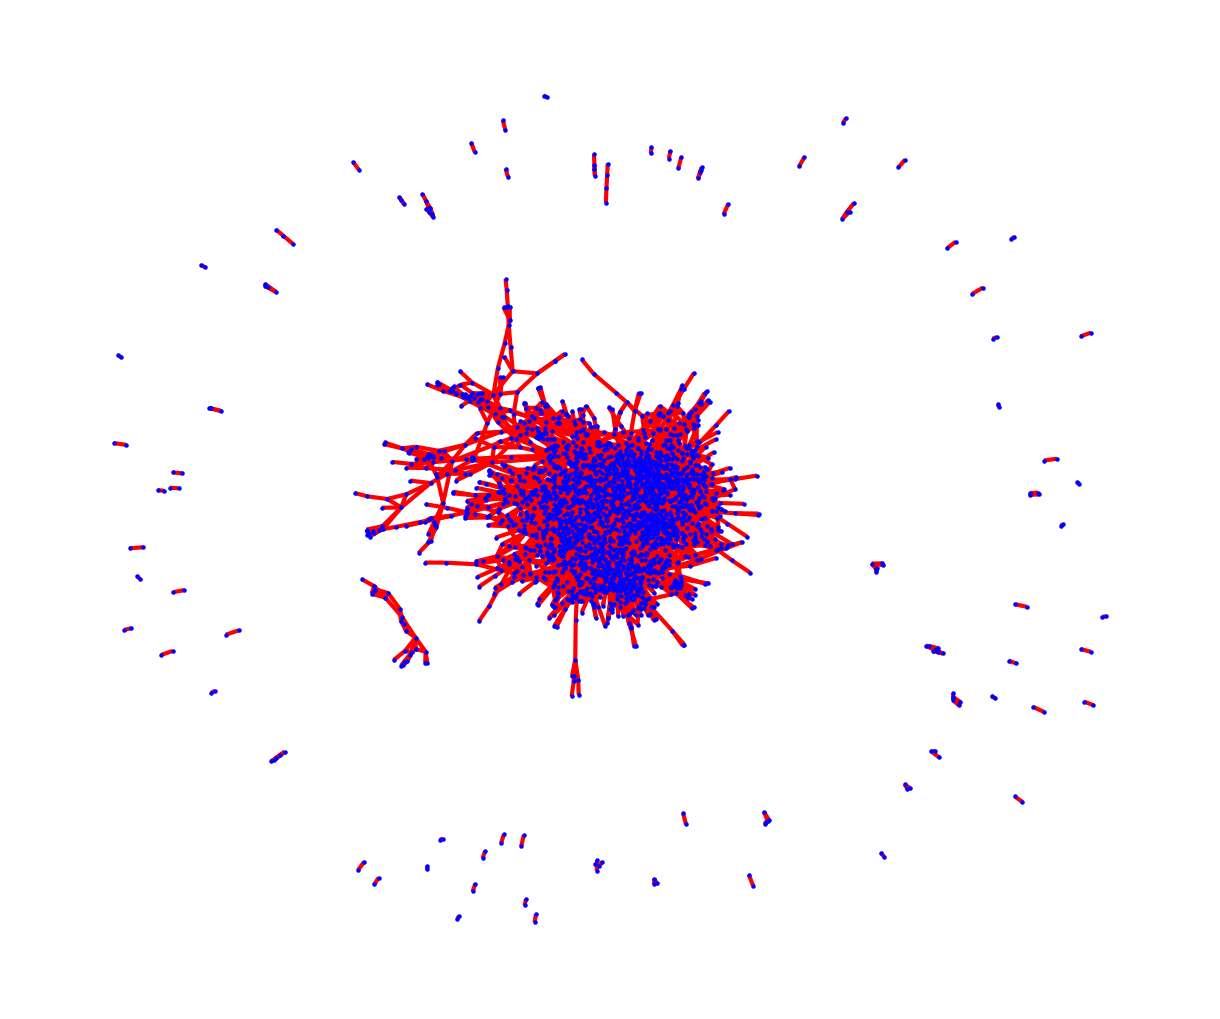

In [13]:
# Dibujar el grafo
pos = nx.spring_layout(grafo)
plt.figure(figsize=(12, 10))
nx.draw(grafo, pos, with_labels=False, node_size=5, width=3, edge_color='red', node_color='blue')
plt.show()

# Mostrar el gráfico
plt.show()


Número de Grafos: 1
Número de clases de nodos: 2
Número de características: 128


In [9]:
graph = dataset[0]

print(f"Número de nodos: {graph.x.shape[0]}")
print(f"Número de características por nodo: {graph.x.shape[1]}")
print(f"Número de aristas: {graph.edge_index.shape[1]}")

Número de nodos: 37700
Número de características por nodo: 128
Número de aristas: 578006


In [10]:
graph.x

tensor([[ 1.4799, -0.6568, -0.1793,  ..., -0.2258,  2.0619,  0.1963],
        [-0.9020, -0.6568, -0.1793,  ..., -0.2420, -0.4832, -0.2165],
        [-0.3659, -0.6568, -0.1793,  ...,  2.5961,  2.0635, -0.2165],
        ...,
        [ 1.2091, -0.6568, -0.1793,  ..., -0.2274, -0.4849, -0.2165],
        [-0.9020, -0.6551, -0.1793,  ..., -0.2420, -0.4854, -0.2079],
        [-0.9020,  1.5236, -0.1793,  ..., -0.2420, -0.4854, -0.2165]])

In [12]:
print("Distribución de Clases:")
sorted(Counter(graph.y.tolist()).items())

Distribución de Clases:


[(0, 27961), (1, 9739)]

In [13]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.cpu().numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(sorted(g.nodes), n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):
    plt.figure(figsize=(12, 10))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 

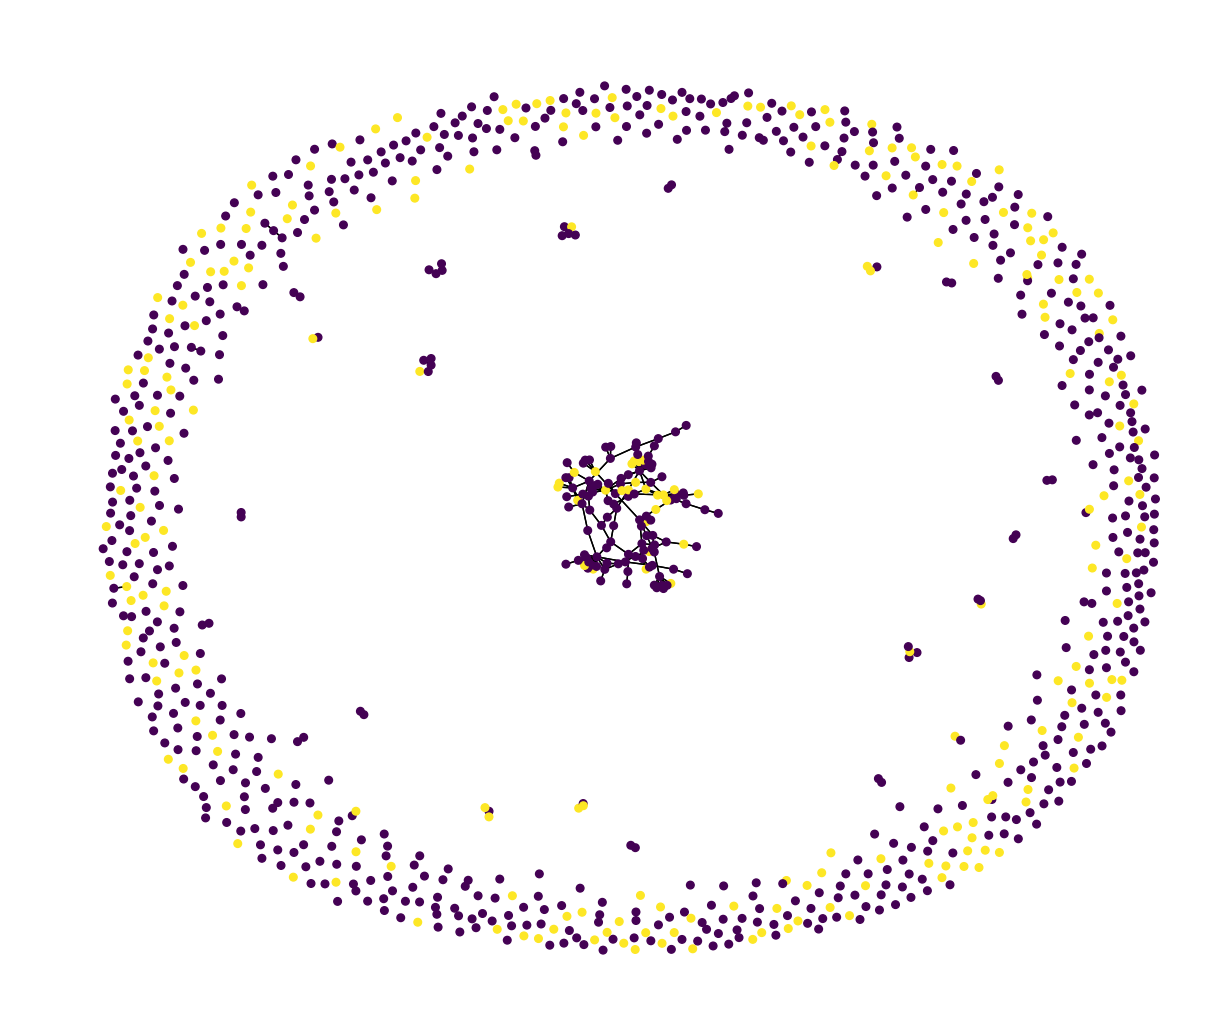

In [15]:
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

In [16]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)
print(
    f"Entrenamiento: {int(graph.train_mask.sum())}, ",
    f"Validación: {int(graph.val_mask.sum())}, ",
    f"Test: {int(graph.test_mask.sum())}",
)

Entrenamiento: 26390,  Validación: 3770,  Test: 7540


In [17]:
from pygod.utils import load_data

# graph = load_data('inj_cora').to(device)
graph = dataset[0]

from pygod.detector import DOMINANT
from sklearn.metrics import roc_auc_score, average_precision_score

graph.y = graph.y.bool()
model = DOMINANT()
model = model.fit(graph)
outlier_scores = model.decision_function(graph)
auc = roc_auc_score(graph.y.cpu().numpy(), outlier_scores)
ap = average_precision_score(graph.y.cpu().numpy(), outlier_scores)
print(f'AUC Score: {auc:.3f}')
print(f'AP Score: {ap:.3f}')

AUC Score: 0.484
AP Score: 0.241
